In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import sys
sys.path.append("..")
from generateTrajectory import *
from armControl import *
from forwardKinematics import robot_config
from utils.motor_setup import Motors
import signal

import generateTrajectory
import matplotlib.pyplot as plt


In [2]:
def signal_handler(signal, frame):
    motors.tcp_close()
signal.signal(signal.SIGINT, signal_handler)
#script_dir = os.path.dirname(__file__)
#results_dir = os.path.join(script_dir, 'Current_data/')
#if not os.path.isdir(results_dir):
#os.makedirs(results_dir)
#Constants
socket_ip = '192.168.1.20'
socket_port = 1122
P = 0
PL = 0
I = 0
IL = 0
D = 0
motors = Motors(P ,PL ,I, IL ,D)

In [3]:
trajPlanner = trajectoryGenerator()

In [4]:
motors.tcp_init(socket_ip, socket_port)

Opening socket at ip: 192.168.1.20 using port: 1122


In [5]:
print("Arming motors now...")
motors.arm_motors()

Arming motors now...
initializing motors to [0 0 0 0 0 0 0 0]
*** C side has an error or needs to be armed ***

Arming motors


In [6]:
setpoint = np.zeros(8)
dt = 0.005
runtime = 1
num_elements = int(runtime/dt)
frequency = 0.5

trajectory = trajPlanner.createTrajectoryNumPoints(setpoint, np.zeros(8), int(1/dt)).astype(int)
for i in range(trajectory.shape[1]):
    setpoint = list(trajectory[:,i].astype(int))
    motors.command_motors(list(trajectory[:,i].astype(int)))
    time.sleep(dt)
setpoint = np.zeros(8)
while motors.avg_current < 0.5:
    setpoint = setpoint + 40
    motors.command_motors(setpoint)
    time.sleep(0.01)
zero_left = motors.motor_encoders_data
trajectory = trajPlanner.createTrajectoryNumPoints(setpoint, np.zeros(8), int(1/dt)).astype(int)
for i in range(trajectory.shape[1]):
    setpoint = list(trajectory[:,i].astype(int))
    motors.command_motors(list(trajectory[:,i].astype(int)))
    time.sleep(dt)
setpoint = np.zeros(8)
currents_mA = []
motor_counts = []
while motors.avg_current < 0.5:
    setpoint = setpoint - 40
    motors.command_motors(setpoint)
    currents_mA.append(1000*motors.avg_current)
    motor_counts.append(motors.motor_encoders_data)
    time.sleep(0.01)
    
zero_right = motors.motor_encoders_data
true_zero = (zero_right + zero_left)/2

trajectory = trajPlanner.createTrajectoryNumPoints(setpoint, true_zero, int(1/dt)).astype(int)
for i in range(trajectory.shape[1]):
    setpoint = list(trajectory[:,i].astype(int))
    motors.command_motors(list(trajectory[:,i].astype(int)))
    time.sleep(dt)
    


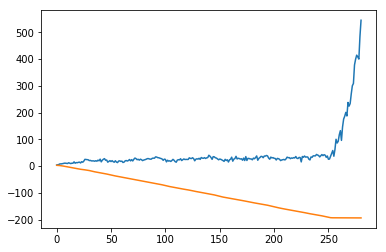

In [7]:
currents_mA = np.array(currents_mA)
motor_counts = np.array(motor_counts)
plt.plot(currents_mA)
plt.plot(motor_counts[:,7] / 50)

In [8]:
dt = 0.005
runtime = 3
num_elements = int(runtime/dt)
setpoints = np.zeros((num_elements, 8))
frequency = 0.5
for i in range(num_elements):
    setpoints[i,:] = (np.ones(8) * np.sin(i*dt*2*pi*frequency)*8000).astype(int)

setpoints = setpoints + true_zero

start_time = time.time()

currents_mA = []
for i in range(num_elements):
    current_time = time.time()
    #print(enc_position)
    setpoint = setpoints[i]
    motors.command_motors(setpoint)
    currents_mA.append(1000*motors.avg_current)
    time.sleep(dt)
    
trajectory = trajPlanner.createTrajectoryNumPoints(setpoint, true_zero, int(1/dt)).astype(int)
for i in range(trajectory.shape[1]):
    setpoint = list(trajectory[:,i].astype(int))
    motors.command_motors(list(trajectory[:,i].astype(int)))
    time.sleep(dt)
    #print(setpoint)


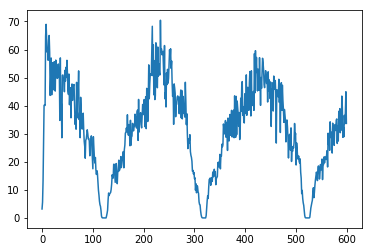

In [9]:
plt.plot(currents_mA)